# Word2Vec + LSTM

# Instalación de librerias

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Cargar el Corpus

In [2]:
df = pd.read_csv("../input/datos01/datos.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8918 entries, 0 to 8917
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   desp_clean_final  8901 non-null   object
 1   INCIBE TAXONOMY   8918 non-null   object
dtypes: object(2)
memory usage: 139.5+ KB


In [4]:
df.head()

,desp_clean_final,INCIBE TAXONOMY
0,compani websit breach sometim around februari ...,HC
1,decemb 29 2011 theft laptop park car san franc...,DL
2,bdo contract rubio perform financi audit servi...,DL
3,februari 10 2012 dhi mortgag becam awar softwa...,HC
4,offic burglari new year eve 2011 result loss h...,DL


In [5]:
print(len(df))

8918


In [6]:
df1 = df.dropna(axis='index',how='any') 

In [7]:
print(len(df))
print(len(df1))

8918
8901


In [8]:
df1.head()

,desp_clean_final,INCIBE TAXONOMY
0,compani websit breach sometim around februari ...,HC
1,decemb 29 2011 theft laptop park car san franc...,DL
2,bdo contract rubio perform financi audit servi...,DL
3,februari 10 2012 dhi mortgag becam awar softwa...,HC
4,offic burglari new year eve 2011 result loss h...,DL


In [9]:
labels = sorted(df1['INCIBE TAXONOMY'].unique())
labels

['DL', 'DOI', 'HC', 'OTHERS', 'PAC', 'THEFT', 'UAI']

In [10]:
df1['INCIBE TAXONOMY'].value_counts() #datos desbalaneceados

HC        2527
DOI       1854
THEFT     1728
DL        1416
OTHERS     702
PAC        606
UAI         68
Name: INCIBE TAXONOMY, dtype: int64

# Visualizacion

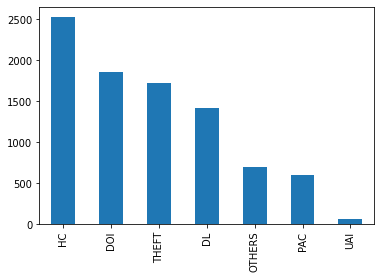

In [11]:
import matplotlib.pyplot as plt
df1['INCIBE TAXONOMY'].value_counts().plot.bar()
plt.show()

# Split Data for Train and Test


Vectorizar la descripción

In [12]:
# Maximo numero de palabras usadas
MAX_NB_WORDS = 50000
# Maximo numero de palabras en cada descripción
MAX_SEQUENCE_LENGTH = 300
# La dimensión del embeding
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df1['desp_clean_final'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13616 unique tokens.


In [13]:
print(word_index)

{'inform': 1, 'breach': 2, 'number': 3, 'secur': 4, 'name': 5, 'locat': 6, 'employe': 7, 'social': 8, 'address': 9, 'access': 10, 'card': 11, 'may': 12, 'patient': 13, 'data': 14, 'custom': 15, 'includ': 16, 'date': 17, 'theft': 18, 'person': 19, 'contain': 20, 'unauthor': 21, 'account': 22, 'email': 23, 'affect': 24, 'credit': 25, 'comput': 26, 'record': 27, 'offic': 28, 'use': 29, 'health': 30, 'laptop': 31, 'provid': 32, 'incid': 33, 'expos': 34, 'compani': 35, 'birth': 36, 'stolen': 37, 'servic': 38, 'medic': 39, 'system': 40, 'file': 41, 'discov': 42, 'report': 43, 'hacker': 44, 'investig': 45, 'notifi': 46, 'accessdisclosur': 47, 'student': 48, 'gener': 49, 'password': 50, 'attorney': 51, 'compromis': 52, 'former': 53, 'individu': 54, 'one': 55, 'also': 56, 'websit': 57, 'peopl': 58, 'hackingit': 59, 'payment': 60, 'state': 61, 'result': 62, 'bank': 63, 'sent': 64, 'server': 65, 'onlin': 66, 'indiana': 67, 'phone': 68, 'user': 69, 'univers': 70, 'two': 71, 'document': 72, 'curren

In [14]:
X = tokenizer.texts_to_sequences(df1['desp_clean_final'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8901, 300)


In [15]:
print(X[0:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [16]:
Y = pd.get_dummies(df1['INCIBE TAXONOMY']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (8901, 7)


In [17]:
print(Y[0:10])

[[0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [18]:
max_length=0
for descp_number in range(len(X)):
  numofwords=len(X[descp_number])
  if(numofwords)>(max_length):
    max_length = numofwords
print(max_length) 

300


In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
data = pad_sequences(X, maxlen = max_length)
y = np.asarray(Y)
print(data)
print('Shape of descriptions tensor: ', data.shape)
print('Shape of label tensor: ', y.shape)

[[   0    0    0 ... 4259   54   24]
 [   0    0    0 ...  453   22    1]
 [   0    0    0 ...    8    4    3]
 ...
 [   0    0    0 ...    2    1   18]
 [   0    0    0 ...    2    1   18]
 [   0    0    0 ...    2    1   18]]
Shape of descriptions tensor:  (8901, 300)
Shape of label tensor:  (8901, 7)


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(data,y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8010, 300) (8010, 7)
(891, 300) (891, 7)


In [21]:
#import gensim.downloader as api
#w2v_model = api.load("../input/word2vec/GoogleNews-vectors-negative300.bin")

In [22]:
import tensorflow as tf
from gensim.models import KeyedVectors
from gensim import models

In [23]:
word2vec_path = '../input/word2vec/GoogleNews-vectors-negative300.bin'
w2v_model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [24]:
unique_words = len(word_index)
total_words = unique_words+1
skipped_words = 0
embedding_dim = 300
embedding_matrix = np.zeros((total_words,embedding_dim))
for word, index in tokenizer.word_index.items():
  try:
    embedding_vector = w2v_model[word]
  except:
    skipped_words = skipped_words+1
    pass
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
print("Embedding Matrix shape: ", embedding_matrix.shape)  

Embedding Matrix shape:  (13617, 300)


In [25]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable = False)

In [26]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Red Neuronal LSTM + capa de embedding con Word2Vec

In [27]:
# LSTM model + Adamax
modelx01 = Sequential()
modelx01.add(embedding_layer)
modelx01.add(LSTM(units=300, use_bias=False, return_sequences=True))
modelx01.add(BatchNormalization())
modelx01.add(Activation('relu'))
modelx01.add(LSTM(units=200,use_bias=False, return_sequences=True))
modelx01.add(BatchNormalization())
modelx01.add(Activation('relu'))
modelx01.add(LSTM(units=100,use_bias=False, return_sequences=False))
modelx01.add(BatchNormalization())
modelx01.add(Activation('relu'))
modelx01.add(Dense(units=7, activation='softmax'))

#modelx01.compile(loss = 'mse', optimizer = 'adamax', metrics=['F1Score'])
# compile the model
#probar con esta funcion de perdida
#categorical_crossentropy 
modelx01.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
print(modelx01.summary())

2022-06-14 10:27:57.998490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 10:27:58.109973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 10:27:58.110811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 10:27:58.112153: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4085100   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 300)          720000    
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300)          1200      
_________________________________________________________________
activation (Activation)      (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 200)          400000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 200)          800       
_________________________________________________________________
activation_1 (Activation)    (None, 300, 200)          0

In [28]:
epochs=10
batch_size=16
#histoty_modelx01 = modelx01.fit(X_train,Y_train,epochs=epochs,batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

# fit the model
history_modelx01 = modelx01.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, verbose=1,batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

2022-06-14 10:28:01.699480: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
351/351 [==============================] - 607s 2s/step - loss: 0.9986 - accuracy: 0.6453 - f1_m: 0.6180 - precision_m: 0.8463 - recall_m: 0.4974 - val_loss: 1.6056 - val_accuracy: 0.3034 - val_f1_m: 0.0208 - val_precision_m: 0.1589 - val_recall_m: 0.0112
Epoch 2/10
351/351 [==============================] - 614s 2s/step - loss: 0.6723 - accuracy: 0.7710 - f1_m: 0.7547 - precision_m: 0.8892 - recall_m: 0.6625 - val_loss: 0.6160 - val_accuracy: 0.7998 - val_f1_m: 0.7875 - val_precision_m: 0.9098 - val_recall_m: 0.6998
Epoch 3/10
351/351 [==============================] - 616s 2s/step - loss: 0.5420 - accuracy: 0.8199 - f1_m: 0.8077 - precision_m: 0.8954 - recall_m: 0.7405 - val_loss: 0.6361 - val_accuracy: 0.7815 - val_f1_m: 0.7786 - val_precision_m: 0.8434 - val_recall_m: 0.7267
Epoch 4/10
351/351 [==============================] - 652s 2s/step - loss: 0.4377 - accuracy: 0.8546 - f1_m: 0.8473 - precision_m: 0.9079 - recall_m: 0.7983 - val_loss: 0.5889 - val_accuracy: 0.8140 

In [29]:
# evaluate the model
lossx01, accuracyx01, f1_scorex01, precisionx01, recallx01 = modelx01.evaluate(X_test, Y_test, verbose=1)

28/28 [==============================] - 3s 121ms/step - loss: 0.6613 - accuracy: 0.8294 - f1_m: 0.8382 - precision_m: 0.8636 - recall_m: 0.8148


In [30]:
accrx01 = modelx01.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.4f}\n Accuracy: {:0.4f}\n f1_score: {:0.4f}\n Precision: {:0.4f}\n Recall: {:0.4f}'.format(accrx01[0],accrx01[1],accrx01[2],accrx01[3],accrx01[4]))

28/28 [==============================] - 3s 111ms/step - loss: 0.6613 - accuracy: 0.8294 - f1_m: 0.8382 - precision_m: 0.8636 - recall_m: 0.8148
Test set
 Loss: 0.6613
 Accuracy: 0.8294
 f1_score: 0.8382
 Precision: 0.8636
 Recall: 0.8148


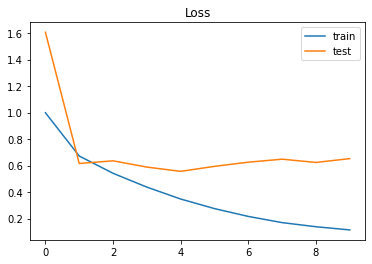

In [31]:
plt.title('Loss')
plt.plot(history_modelx01.history['loss'], label='train')
plt.plot(history_modelx01.history['val_loss'], label='test')
plt.legend()
plt.show();

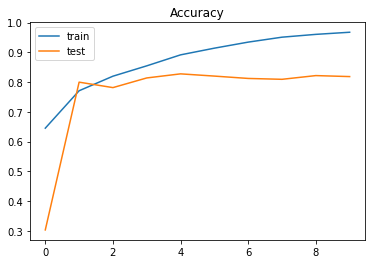

In [32]:
plt.title('Accuracy')
plt.plot(history_modelx01.history['accuracy'], label='train')
plt.plot(history_modelx01.history['val_accuracy'], label='test')
plt.legend()
plt.show();

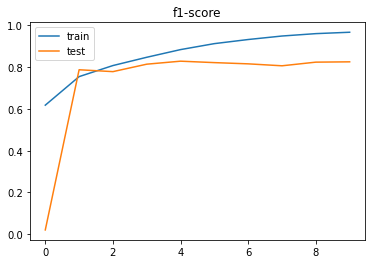

In [33]:
plt.title('f1-score')
plt.plot(history_modelx01.history['f1_m'], label='train')
plt.plot(history_modelx01.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [34]:
y_pred_01 = np.where(modelx01.predict(X_test)>.5,1,0)

In [35]:
from sklearn import metrics
print(metrics.classification_report(y_pred_01, Y_test,digits=4))

              precision    recall  f1-score   support

           0     0.8750    0.8811    0.8780       143
           1     0.7754    0.8480    0.8101       171
           2     0.8826    0.8535    0.8678       273
           3     0.7465    0.9298    0.8281        57
           4     0.5000    0.7027    0.5843        37
           5     0.8606    0.8987    0.8793       158
           6     0.1250    0.5000    0.2000         2

   micro avg     0.8148    0.8633    0.8383       841
   macro avg     0.6807    0.8020    0.7211       841
weighted avg     0.8275    0.8633    0.8432       841
 samples avg     0.8148    0.8148    0.8148       841



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'real')

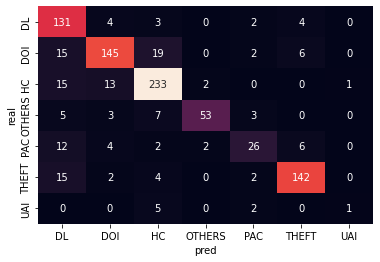

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_LSTM_W2V01= confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_01).argmax(axis=1))
sns.heatmap(mat_LSTM_W2V01, 
            annot = True, 
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels= labels)
plt.xlabel('pred')
plt.ylabel('real')

# Word2Vec + LSTM + ADAM

In [37]:
# LSTM model + Adam
modelx02 = Sequential()
modelx02.add(embedding_layer)
modelx02.add(LSTM(units=300, use_bias=False, return_sequences=True))
modelx02.add(BatchNormalization())
modelx02.add(Activation('relu'))
modelx02.add(LSTM(units=200,use_bias=False, return_sequences=True))
modelx02.add(BatchNormalization())
modelx02.add(Activation('relu'))
modelx02.add(LSTM(units=100,use_bias=False, return_sequences=False))
modelx02.add(BatchNormalization())
modelx02.add(Activation('relu'))
modelx02.add(Dense(units=7, activation='softmax'))

#modelx01.compile(loss = 'mse', optimizer = 'adamax', metrics=['F1Score'])
# compile the model
#probar con esta funcion de perdida
#categorical_crossentropy 
modelx02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
print(modelx02.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4085100   
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 300)          720000    
_________________________________________________________________
batch_normalization_3 (Batch (None, 300, 300)          1200      
_________________________________________________________________
activation_3 (Activation)    (None, 300, 300)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 300, 200)          400000    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300, 200)          800       
_________________________________________________________________
activation_4 (Activation)    (None, 300, 200)         

In [38]:
epochs=10
batch_size=16
# fit the model
history_modelx02 = modelx02.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, verbose=1,batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/10
351/351 [==============================] - 650s 2s/step - loss: 0.9555 - accuracy: 0.6619 - f1_m: 0.6418 - precision_m: 0.8594 - recall_m: 0.5227 - val_loss: 1.4663 - val_accuracy: 0.5639 - val_f1_m: 0.0372 - val_precision_m: 0.2517 - val_recall_m: 0.0203
Epoch 2/10
351/351 [==============================] - 675s 2s/step - loss: 0.7031 - accuracy: 0.7571 - f1_m: 0.7486 - precision_m: 0.8796 - recall_m: 0.6580 - val_loss: 0.6926 - val_accuracy: 0.7511 - val_f1_m: 0.7542 - val_precision_m: 0.8227 - val_recall_m: 0.7002
Epoch 3/10
351/351 [==============================] - 648s 2s/step - loss: 0.5803 - accuracy: 0.8056 - f1_m: 0.8018 - precision_m: 0.8902 - recall_m: 0.7337 - val_loss: 0.6486 - val_accuracy: 0.7824 - val_f1_m: 0.7889 - val_precision_m: 0.8527 - val_recall_m: 0.7379
Epoch 4/10
351/351 [==============================] - 663s 2s/step - loss: 0.5229 - accuracy: 0.8261 - f1_m: 0.8289 - precision_m: 0.8904 - recall_m: 0.7786 - val_loss: 0.6216 - val_accuracy: 0.7944 

In [39]:
accrx02 = modelx02.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.4f}\n Accuracy: {:0.4f}\n f1_score: {:0.4f}\n Precision: {:0.4f}\n Recall: {:0.4f}'.format(accrx02[0],accrx02[1],accrx02[2],accrx02[3],accrx02[4]))

28/28 [==============================] - 3s 117ms/step - loss: 0.7522 - accuracy: 0.8002 - f1_m: 0.8074 - precision_m: 0.8297 - recall_m: 0.7867
Test set
 Loss: 0.7522
 Accuracy: 0.8002
 f1_score: 0.8074
 Precision: 0.8297
 Recall: 0.7867


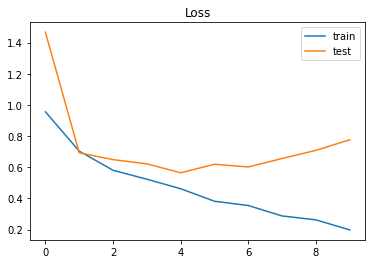

In [40]:
plt.title('Loss')
plt.plot(history_modelx02.history['loss'], label='train')
plt.plot(history_modelx02.history['val_loss'], label='test')
plt.legend()
plt.show();

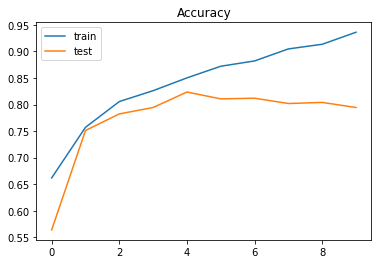

In [41]:
plt.title('Accuracy')
plt.plot(history_modelx02.history['accuracy'], label='train')
plt.plot(history_modelx02.history['val_accuracy'], label='test')
plt.legend()
plt.show();

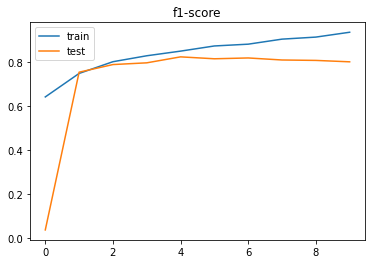

In [42]:
plt.title('f1-score')
plt.plot(history_modelx02.history['f1_m'], label='train')
plt.plot(history_modelx02.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [43]:
y_pred_02 = np.where(modelx02.predict(X_test)>.5,1,0)

In [44]:
from sklearn import metrics
print(metrics.classification_report(y_pred_02, Y_test,digits=4))

              precision    recall  f1-score   support

           0     0.8403    0.8462    0.8432       143
           1     0.5775    0.9153    0.7082       118
           2     0.9053    0.7940    0.8460       301
           3     0.8028    0.7500    0.7755        76
           4     0.6923    0.7200    0.7059        50
           5     0.8424    0.8854    0.8634       157
           6     0.1250    1.0000    0.2222         1

   micro avg     0.7868    0.8286    0.8071       846
   macro avg     0.6837    0.8444    0.7092       846
weighted avg     0.8142    0.8286    0.8142       846
 samples avg     0.7868    0.7868    0.7868       846



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'real')

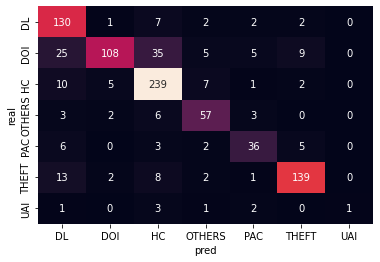

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_LSTM_W2V02= confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_02).argmax(axis=1))
sns.heatmap(mat_LSTM_W2V02, 
            annot = True, 
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels= labels)
plt.xlabel('pred')
plt.ylabel('real')

# Word2Vec + CNN + Adam

In [46]:
embedding_layer_cnn = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable = False)

In [47]:
# CNN model
modelx03 = Sequential()
modelx03.add(embedding_layer)

modelx03.add(Conv1D(filters=300, kernel_size=7, padding='same', activation='relu'))
modelx03.add(MaxPooling1D(pool_size=3))
modelx03.add(BatchNormalization())
modelx03.add(Activation('relu'))

modelx03.add(Conv1D(filters=100, kernel_size=7, padding='same', activation='relu'))
modelx03.add(MaxPooling1D(pool_size=2))
modelx03.add(BatchNormalization())
modelx03.add(Activation('relu'))

modelx03.add(Flatten())
modelx03.add(Dense(units=10, activation='relu'))
modelx03.add(Dense(units=7, activation='softmax'))

# compile the model
modelx03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
print(modelx03.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4085100   
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 300)          630300    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 300)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 100, 300)          1200      
_________________________________________________________________
activation_6 (Activation)    (None, 100, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 100)          210100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 100)          

In [48]:
epochs=10
batch_size=16
# fit the model
history_modelx03 = modelx03.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, verbose=1,batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/10


2022-06-14 14:11:37.657887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


351/351 [==============================] - 12s 13ms/step - loss: 1.0444 - accuracy: 0.6390 - f1_m: 0.6253 - precision_m: 0.9067 - recall_m: 0.4910 - val_loss: 1.0861 - val_accuracy: 0.6846 - val_f1_m: 0.5445 - val_precision_m: 0.9909 - val_recall_m: 0.3856
Epoch 2/10
351/351 [==============================] - 5s 13ms/step - loss: 0.7096 - accuracy: 0.7574 - f1_m: 0.7547 - precision_m: 0.8904 - recall_m: 0.6603 - val_loss: 0.7516 - val_accuracy: 0.7432 - val_f1_m: 0.7312 - val_precision_m: 0.8605 - val_recall_m: 0.6418
Epoch 3/10
351/351 [==============================] - 4s 11ms/step - loss: 0.4942 - accuracy: 0.8372 - f1_m: 0.8381 - precision_m: 0.9067 - recall_m: 0.7824 - val_loss: 0.7664 - val_accuracy: 0.7732 - val_f1_m: 0.7784 - val_precision_m: 0.8367 - val_recall_m: 0.7317
Epoch 4/10
351/351 [==============================] - 4s 12ms/step - loss: 0.3410 - accuracy: 0.8894 - f1_m: 0.8921 - precision_m: 0.9312 - recall_m: 0.8581 - val_loss: 0.7985 - val_accuracy: 0.7853 - val_f1_m

In [49]:
# evaluate the model
lossx03, accuracyx03, f1_scorex03, precisionx03, recallx03 = modelx03.evaluate(X_test, Y_test, verbose=1)

28/28 [==============================] - 0s 6ms/step - loss: 0.8079 - accuracy: 0.7980 - f1_m: 0.8059 - precision_m: 0.8367 - recall_m: 0.7785


In [50]:
accrx03 = modelx03.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.4f}\n Accuracy: {:0.4f}\n f1_score: {:0.4f}\n Precision: {:0.4f}\n Recall: {:0.4f}'.format(accrx03[0],accrx03[1],accrx03[2],accrx03[3],accrx03[4]))

28/28 [==============================] - 0s 5ms/step - loss: 0.8079 - accuracy: 0.7980 - f1_m: 0.8059 - precision_m: 0.8367 - recall_m: 0.7785
Test set
 Loss: 0.8079
 Accuracy: 0.7980
 f1_score: 0.8059
 Precision: 0.8367
 Recall: 0.7785


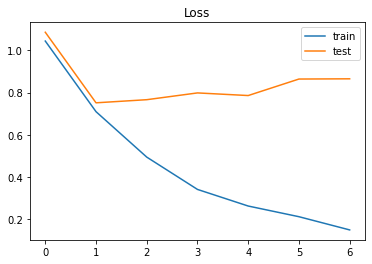

In [51]:
plt.title('Loss')
plt.plot(history_modelx03.history['loss'], label='train')
plt.plot(history_modelx03.history['val_loss'], label='test')
plt.legend()
plt.show();

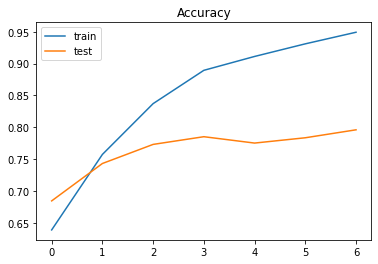

In [52]:
plt.title('Accuracy')
plt.plot(history_modelx03.history['accuracy'], label='train')
plt.plot(history_modelx03.history['val_accuracy'], label='test')
plt.legend()
plt.show();

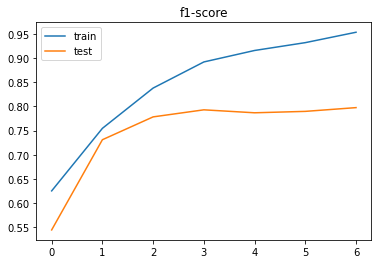

In [53]:
plt.title('f1-score')
plt.plot(history_modelx03.history['f1_m'], label='train')
plt.plot(history_modelx03.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [54]:
y_pred_03 = np.where(modelx03.predict(X_test)>.5,1,0)

In [55]:
from sklearn import metrics
print(metrics.classification_report(y_pred_03, Y_test,digits=4))

              precision    recall  f1-score   support

           0     0.8056    0.8345    0.8198       139
           1     0.6684    0.8224    0.7375       152
           2     0.8939    0.7815    0.8339       302
           3     0.7465    0.9815    0.8480        54
           4     0.5000    0.7647    0.6047        34
           5     0.8364    0.9324    0.8818       148
           6     0.0000    0.0000    0.0000         0

   micro avg     0.7789    0.8372    0.8070       829
   macro avg     0.6358    0.7310    0.6751       829
weighted avg     0.8017    0.8372    0.8139       829
 samples avg     0.7789    0.7789    0.7789       829



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'real')

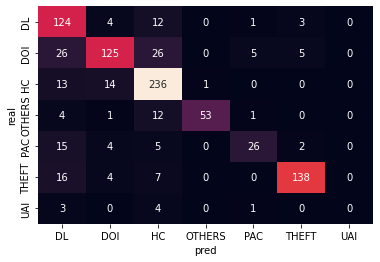

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_CNN_W2V01= confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_03).argmax(axis=1))
sns.heatmap(mat_CNN_W2V01, 
            annot = True, 
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels= labels)
plt.xlabel('pred')
plt.ylabel('real')

In [57]:
#pip freeze (versiones)

# Word2Vec + CNN + ADAMAX

In [58]:
# CNN model + Adamax
modelx04 = Sequential()
modelx04.add(embedding_layer)

modelx04.add(Conv1D(filters=300, kernel_size=7, padding='same', activation='relu'))
modelx04.add(MaxPooling1D(pool_size=3))
modelx04.add(BatchNormalization())
modelx04.add(Activation('relu'))

modelx04.add(Conv1D(filters=100, kernel_size=7, padding='same', activation='relu'))
modelx04.add(MaxPooling1D(pool_size=2))
modelx04.add(BatchNormalization())
modelx04.add(Activation('relu'))

modelx04.add(Flatten())
modelx04.add(Dense(units=10, activation='relu'))
modelx04.add(Dense(units=7, activation='softmax'))

# compile the model
modelx04.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
print(modelx04.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4085100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 300, 300)          630300    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 300)          0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 100, 300)          1200      
_________________________________________________________________
activation_8 (Activation)    (None, 100, 300)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 100)          210100    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 100)          

In [59]:
epochs=10
batch_size=16
# fit the model
history_modelx04 = modelx04.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, verbose=1,batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/10
351/351 [==============================] - 6s 13ms/step - loss: 1.1337 - accuracy: 0.6107 - f1_m: 0.5648 - precision_m: 0.9137 - recall_m: 0.4294 - val_loss: 1.3412 - val_accuracy: 0.7079 - val_f1_m: 0.1231 - val_precision_m: 0.6821 - val_recall_m: 0.0693
Epoch 2/10
351/351 [==============================] - 4s 11ms/step - loss: 0.6744 - accuracy: 0.7780 - f1_m: 0.7575 - precision_m: 0.9285 - recall_m: 0.6472 - val_loss: 0.7758 - val_accuracy: 0.7449 - val_f1_m: 0.7266 - val_precision_m: 0.9274 - val_recall_m: 0.6046
Epoch 3/10
351/351 [==============================] - 4s 11ms/step - loss: 0.3644 - accuracy: 0.8876 - f1_m: 0.8796 - precision_m: 0.9493 - recall_m: 0.8234 - val_loss: 0.8025 - val_accuracy: 0.7412 - val_f1_m: 0.7463 - val_precision_m: 0.8570 - val_recall_m: 0.6658
Epoch 4/10
351/351 [==============================] - 4s 12ms/step - loss: 0.2092 - accuracy: 0.9447 - f1_m: 0.9433 - precision_m: 0.9670 - recall_m: 0.9222 - val_loss: 0.8194 - val_accuracy: 0.7561 

In [60]:
# evaluate the model
lossx04, accuracyx04, f1_scorex04, precisionx04, recallx04 = modelx04.evaluate(X_test, Y_test, verbose=1)

28/28 [==============================] - 0s 5ms/step - loss: 0.8520 - accuracy: 0.7744 - f1_m: 0.7760 - precision_m: 0.8238 - recall_m: 0.7343


In [61]:
accrx04 = modelx04.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.4f}\n Accuracy: {:0.4f}\n f1_score: {:0.4f}\n Precision: {:0.4f}\n Recall: {:0.4f}'.format(accrx04[0],accrx04[1],accrx04[2],accrx04[3],accrx04[4]))

28/28 [==============================] - 0s 6ms/step - loss: 0.8520 - accuracy: 0.7744 - f1_m: 0.7760 - precision_m: 0.8238 - recall_m: 0.7343
Test set
 Loss: 0.8520
 Accuracy: 0.7744
 f1_score: 0.7760
 Precision: 0.8238
 Recall: 0.7343


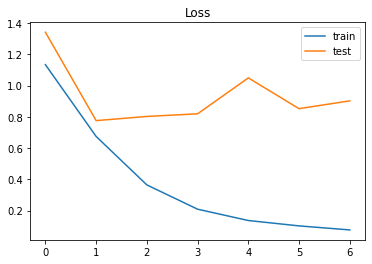

In [62]:
plt.title('Loss')
plt.plot(history_modelx04.history['loss'], label='train')
plt.plot(history_modelx04.history['val_loss'], label='test')
plt.legend()
plt.show();

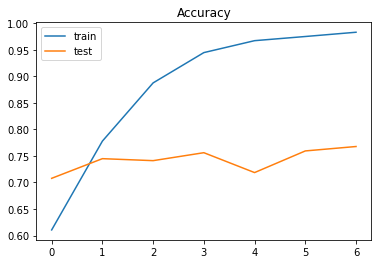

In [63]:
plt.title('Accuracy')
plt.plot(history_modelx04.history['accuracy'], label='train')
plt.plot(history_modelx04.history['val_accuracy'], label='test')
plt.legend()
plt.show();

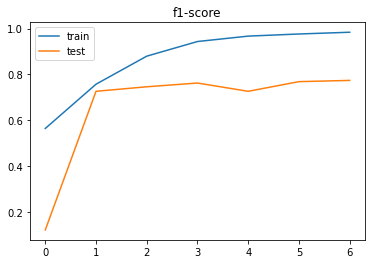

In [64]:
plt.title('f1-score')
plt.plot(history_modelx04.history['f1_m'], label='train')
plt.plot(history_modelx04.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [65]:
y_pred_04 = np.where(modelx04.predict(X_test)>.5,1,0)

In [66]:
from sklearn import metrics
print(metrics.classification_report(y_pred_04, Y_test,digits=4))

              precision    recall  f1-score   support

           0     0.7847    0.7847    0.7847       144
           1     0.6257    0.8478    0.7200       138
           2     0.7917    0.8566    0.8228       244
           3     0.7465    0.9636    0.8413        55
           4     0.4808    0.6250    0.5435        40
           5     0.8364    0.7977    0.8166       173
           6     0.0000    0.0000    0.0000         0

   micro avg     0.7351    0.8249    0.7774       794
   macro avg     0.6094    0.6965    0.6470       794
weighted avg     0.7525    0.8249    0.7839       794
 samples avg     0.7351    0.7351    0.7351       794



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'real')

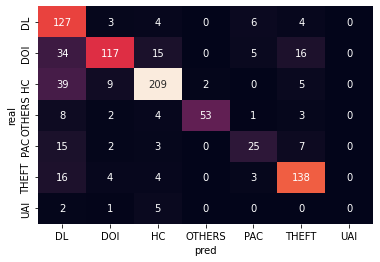

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_CNN_W2V02= confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_04).argmax(axis=1))
sns.heatmap(mat_CNN_W2V02, 
            annot = True, 
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels= labels)
plt.xlabel('pred')
plt.ylabel('real')

# Comparación modelos

In [68]:
def show_values_on_bars(axs, h_v="v", space=0.2):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = "{:.2f}".format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = "{:.2f}".format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

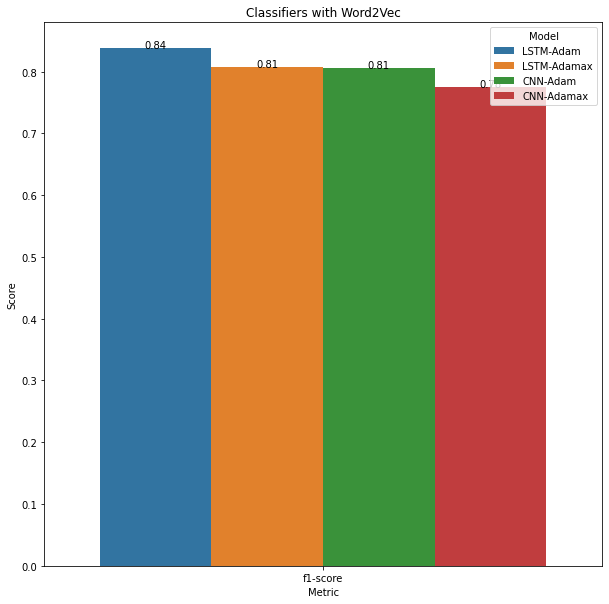

In [69]:
results=[]
#Test
results.append([accrx01[2], 'f1-score', 'LSTM-Adam'])
results.append([accrx02[2], 'f1-score', 'LSTM-Adamax'])
results.append([accrx03[2], 'f1-score', 'CNN-Adam'])
results.append([accrx04[2], 'f1-score', 'CNN-Adamax'])

comparison = pd.DataFrame(results, columns = ['Score', 'Metric', 'Model'])

plt.figure(figsize=(10,10))
plt.title("Classifiers with Word2Vec")
plot = sns.barplot(x=comparison['Metric'],y=comparison['Score'], hue = comparison['Model'])

show_values_on_bars(plot)